## Run Structure Function Analysis on All Relevant OpSims (WFD Only)
**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 04-15-21
<br>**Short description:**
This notebook analyze the SFErrorMetric results evaluated on __All__ OpSims in preparation for the SCOC cadence notes on structure function analysis in LSST.

### 0. Software Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')
%matplotlib inline

In [2]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add path
sys.path.insert(0, '../scripts/')
sys.path.insert(0, '../run_info//')

# import convenience functions
from opsimUtils import *

### 1. Read data from disk

In [4]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/WFDAll_g_24_gr_041521/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/WFDAll_g_24_gr_041521/MetricData/'

In [5]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [6]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'SFError_23.85_r'), (2, 'SFError_24.15_u')]


#### Keep only result for the relevant OpSims

In [7]:
# read in the list of relevant runs
runs_file = open('../run_info/runs_list.txt', 'r')
runs_list = runs_file.read().split('\n')
runs_list[:5]

['agnddf_v1.5_10yrs',
 'alt_dust_v1.5_10yrs',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs',
 'barebones_nexp2_v1.6_10yrs',
 'barebones_v1.6_10yrs']

In [8]:
# select metric results for the relevant opsims
final_bundleDicts = {key:value for (key, value) in bundleDicts.items() if key in runs_list}
final_resultDbs = {key:value for (key, value) in resultDbsView.items() if key in runs_list}

### 2. Make plots

In [9]:
# take Lynne's notes on families
import run_infos as ri

# gather family info, but remove version_baselines
families = ri.FamilyInfo()
fam_db = {key:value for (key, value) in 
          families.family.items() if key != 'version_baselines'}
family_ls = list(fam_db.keys())
comp_runs = {key:value for (key, value) in 
             families.family_baseline.items() if key != 'version_baselines'}

In [19]:
# get the metrics for plotting
# Key1, Key2 = (2, 'SFError_24.15_u'), (4, 'SFError_24_g')
KeyNames = ['SFError_24.15_u', 'SFError_23.85_r']

#### 2.1 Get summary statistics (Median, Mean, etc.)

In [20]:
# get summary names
summaryNames = getSummaryStatNames(final_resultDbs['baseline_v1.5_10yrs'], 
                                   KeyNames[0])[0]['StatNames']

# loop through metric Keys and summaries -> combine into one pandas df
summary_dfs = []
for KeyName in KeyNames:
    for summaryName in ['Median']:
        summary_df = getSummary(
            final_resultDbs, 
            KeyName, 
            summaryName)[['summaryValue', 'runName']].rename(columns={'summaryValue':
                                                            f'{KeyName}_{summaryName}'})
        summary_dfs.append(summary_df.set_index('runName'))

summary_df_all = summary_dfs[0].join(summary_dfs[1:]).reset_index()

In [21]:
# assign family
unique_comp_runs = np.unique(list(comp_runs.values()))
summary_df_all['family'] = ''
for familyName in comp_runs:
    non_comp_runs = [run for run in fam_db[familyName] if run is not comp_runs[familyName]]
    summary_df_all.loc[summary_df_all.runName.isin(non_comp_runs), 'family'] = familyName

# if not assigned, it must be one of the baselines
summary_df_all.loc[summary_df_all.runName.isin(unique_comp_runs), 'family'] = 'baseline'

# sort by family
summary_df_all = summary_df_all.sort_values('family').set_index('runName')

In [22]:
# remove ddf family
non_ddf_rows = [row 
                for row 
                in summary_df_all.index 
                if not (('ddf' in row and 'noddf' not in row) or ('dither' in row))]
summary_df_no_ddf = summary_df_all.loc[non_ddf_rows, :]

#### 2.2 Pick the best (according to median values) from each family and plot summary/distributions

In [24]:
# define normalizing run
norm_run = 'baseline_v1.5_10yrs'
norm_metric_u = summary_df_all.loc[norm_run, 'SFError_24.15_u_Median']
# norm_metric_g = summary_df_all.loc[norm_run, 'SFError_24_g_Median']
norm_metric_r = summary_df_all.loc[norm_run, 'SFError_23.85_r_Median']

##### 2.2.1 `SFError_24.15_u`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

Text(0.5, 1.0, 'Best one from every family (24.15_u)')

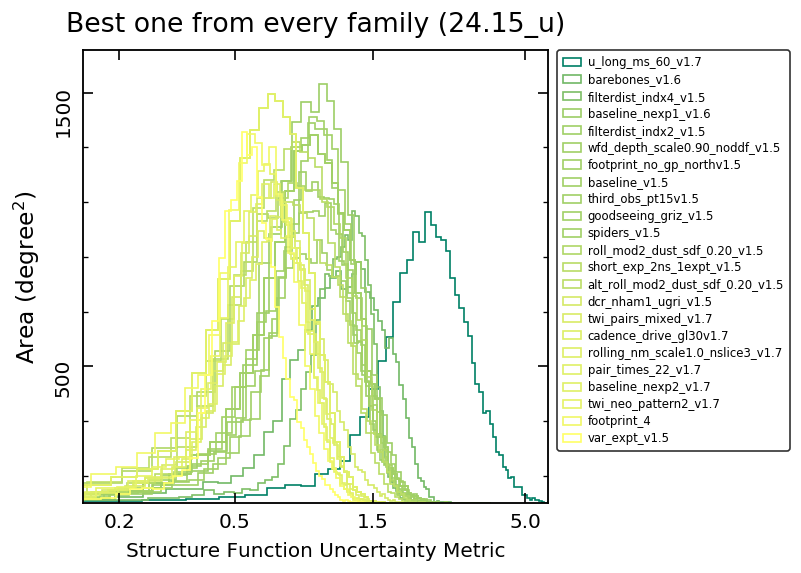

In [25]:
# sort by family and median
# take the best from each family, but keep all three baselines
best_u_family_no_baseline = summary_df_no_ddf[
    summary_df_no_ddf.family != 'baseline'
].sort_values(['family', 'SFError_24.15_u_Median']).drop_duplicates(subset='family')

best_u_family = pd.concat([summary_df_no_ddf[summary_df_no_ddf.family == 'baseline'], 
                           best_u_family_no_baseline], 
                           axis=0).sort_values('SFError_24.15_u_Median')

# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# create normalization object
uNorm = mpl.colors.LogNorm(vmin=best_u_family['SFError_24.15_u_Median'].min(), 
                           vmax=best_u_family['SFError_24.15_u_Median'].max())
bins = 60
density = False

for run in best_u_family.index:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_24.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNorm(best_u_family.loc[run, 'SFError_24.15_u_Median']))
    ax.hist(norm_metric_u/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# # plot r
# for run in best_r_family.index:
    
#     # match keys
#     keys = [*final_bundleDicts[run].keys()]
#     metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
#     # need to mask the pixels that have no available data
#     mask = final_bundleDicts[run][metricKey].metricValues.mask
#     data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
#     data = data[~(np.isnan(data) | np.isinf(data))]
    
# #     c = mpl.cm.summer(rNorm(best_r_family.loc[run, 'SFError_23.85_r_Median']))
#     ax.hist(norm_metric_r/data, bins=bins, histtype='step', color='k', alpha=0.1, 
#             density=density)

    
# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.15, upper=6)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.2, .5, 1.5, 5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
ax.legend(fontsize=7, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.35)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1500, 2500])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best one from every family (24.15_u)')

Text(0.5, 1.0, 'Best 10 & Worst 10 (24.15_u)')

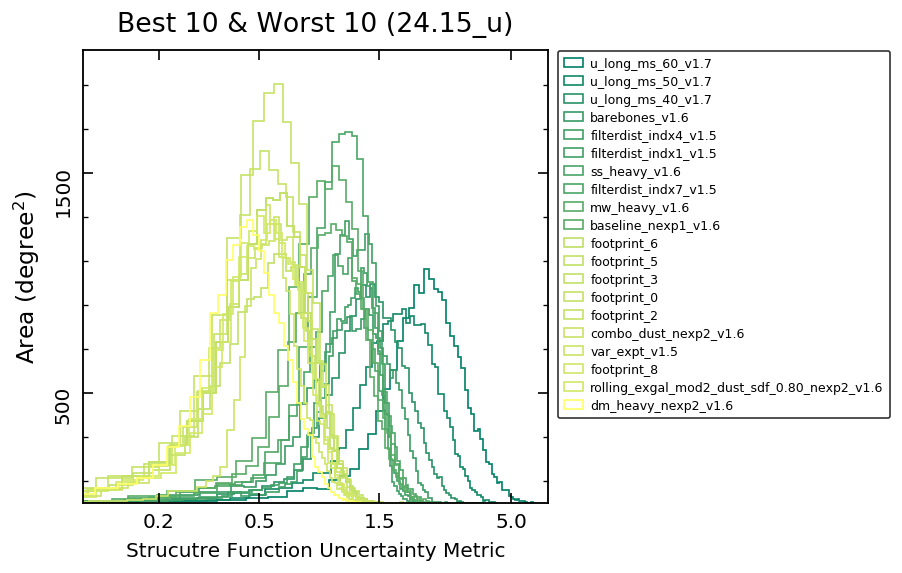

In [26]:
# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# resort by metric value
summary_df_no_ddf = summary_df_no_ddf.sort_values('SFError_24.15_u_Median')

# create normalization object
uNormAll = mpl.colors.Normalize(vmin=summary_df_no_ddf['SFError_24.15_u_Median'].min(), 
                                vmax=summary_df_no_ddf['SFError_24.15_u_Median'].max())
bins = 60
density = False

# plot top 10
for run in summary_df_no_ddf.index[:10]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_24.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(summary_df_no_ddf.loc[run, 'SFError_24.15_u_Median']))
    ax.hist(norm_metric_u/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# plot worst 10
for run in summary_df_no_ddf.index[-10:]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_24.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(summary_df_no_ddf.loc[run, 'SFError_24.15_u_Median']))
    ax.hist(norm_metric_u/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# ## r band
# # -------------------------------------------------------------------------------------
# summary_df_no_ddf = summary_df_no_ddf.sort_values('SFError_23.85_r_Median')
# # plot top 10
# for run in summary_df_no_ddf.index[:10]:
    
#     # match keys
#     keys = [*final_bundleDicts[run].keys()]
#     metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
#     # need to mask the pixels that have no available data
#     mask = final_bundleDicts[run][metricKey].metricValues.mask
#     data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
#     data = data[~(np.isnan(data) | np.isinf(data))]
    
# #     c = mpl.cm.summer(rNormAll(summary_df_no_ddf.loc[run, 'SFError_23.85_r_Median']))
#     ax.hist(norm_metric_r/data, bins=bins, histtype='step', color='k', alpha=0.1, 
#              density=density)

# # plot worst 10
# for run in summary_df_no_ddf.index[-10:]:
    
#     # match keys
#     keys = [*final_bundleDicts[run].keys()]
#     metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
#     # need to mask the pixels that have no available data
#     mask = final_bundleDicts[run][metricKey].metricValues.mask
#     data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
#     data = data[~(np.isnan(data) | np.isinf(data))]
    
# #     c = mpl.cm.summer(rNormAll(summary_df_no_ddf.loc[run, 'SFError_23.85_r_Median']))
#     ax.hist(norm_metric_r/data, bins=bins, histtype='step', color='k', alpha=0.1,
#              density=density)
# # -------------------------------------------------------------------------------------

# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.1, upper=7)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.2, .5, 1.5, 5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('Strucutre Function Uncertainty Metric', fontsize=12)
ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1500, 2500])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best 10 & Worst 10 (24.15_u)')

##### 2.2.2 `SFError_23.85_r`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

Text(0.5, 1.0, 'Best one from every family (23.85_r)')

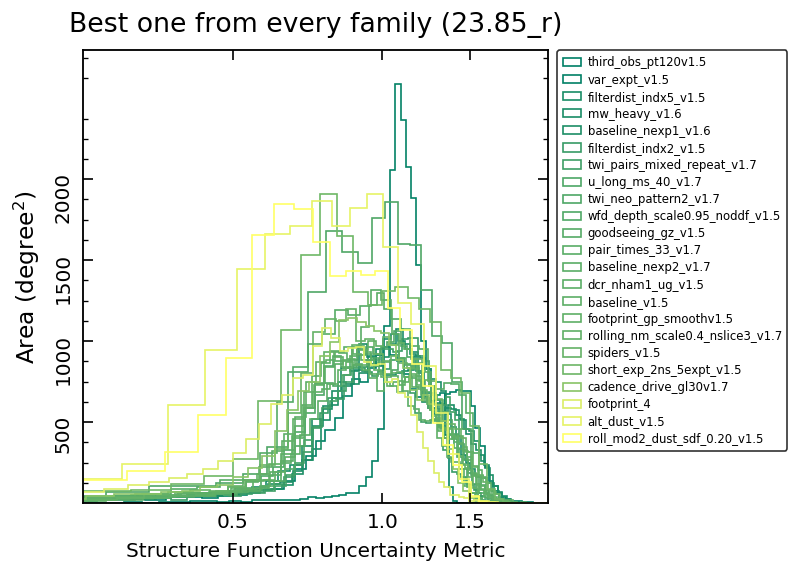

In [27]:
# sort by family and median
# take the best from each family, but keep all three baselines
best_r_family_no_baseline = summary_df_no_ddf[
    summary_df_no_ddf.family != 'baseline'
].sort_values(['family', 'SFError_23.85_r_Median']).drop_duplicates(subset='family')

best_r_family = pd.concat([summary_df_no_ddf[summary_df_no_ddf.family == 'baseline'], 
                           best_r_family_no_baseline], 
                           axis=0).sort_values('SFError_23.85_r_Median')

# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# create normalization object
rNorm = mpl.colors.LogNorm(vmin=best_r_family['SFError_23.85_r_Median'].min(), 
                           vmax=best_r_family['SFError_23.85_r_Median'].max())
bins = 60
density = False

for run in best_r_family.index:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(rNorm(best_r_family.loc[run, 'SFError_23.85_r_Median']))
    ax.hist(norm_metric_r/data, bins=bins, histtype='step', color=c, 
            density=density, label=f"{run.rsplit('_', 1)[0]}")

# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.25, upper=2.15)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.5, 1, 1.5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
ax.legend(fontsize=7, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.35)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best one from every family (23.85_r)')

Text(0.5, 1.0, 'Best 10 & Worst 10 (23.85_r)')

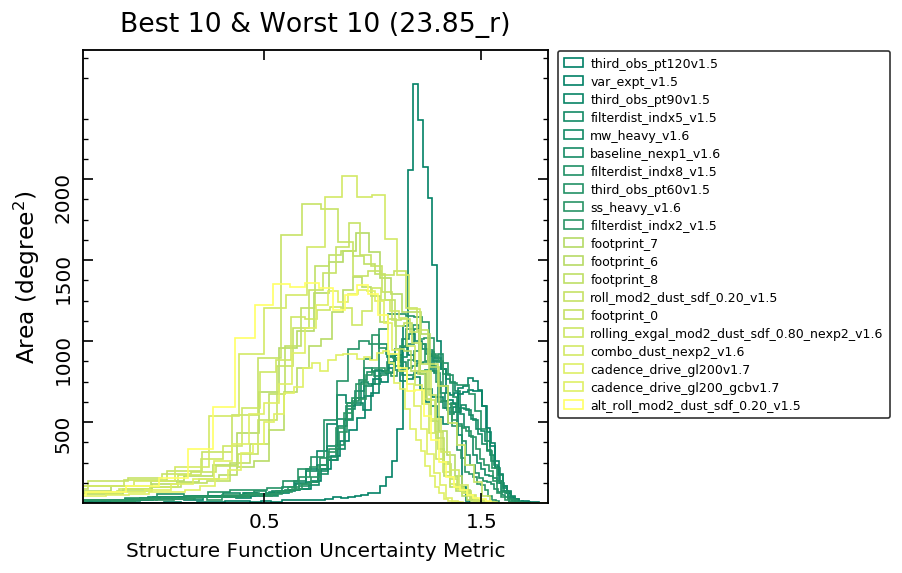

In [28]:
# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# resort by metric value
summary_df_no_ddf = summary_df_no_ddf.sort_values('SFError_23.85_r_Median')

# create normalization object
rNormAll = mpl.colors.LogNorm(vmin=summary_df_no_ddf['SFError_23.85_r_Median'].min(), 
                              vmax=summary_df_no_ddf['SFError_23.85_r_Median'].max())

bins = 60
density = False

# plot top 10
for run in summary_df_no_ddf.index[:10]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(rNormAll(summary_df_no_ddf.loc[run, 'SFError_23.85_r_Median']))
    ax.hist(norm_metric_r/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# plot worst 10
for run in summary_df_no_ddf.index[-10:]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(rNormAll(summary_df_no_ddf.loc[run, 'SFError_23.85_r_Median']))
    ax.hist(norm_metric_r/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")


# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.2, upper=2.1)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.1, .5, 1.5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best 10 & Worst 10 (23.85_r)')

##### 2.2.3 `SFError_24_g`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

In [ ]:
# # sort by family and median
# # take the best from each family, but keep all three baselines
# best_g_family_no_baseline = summary_df_all[
#     summary_df_all.family != 'baseline'
# ].sort_values(['family', 'SFError_24_g_Median']).drop_duplicates(subset='family')

# best_g_family = pd.concat([summary_df_all[summary_df_all.family == 'baseline'], 
#                            best_g_family_no_baseline], 
#                           axis=0).sort_values('SFError_24_g_Median')

# # plot distribution
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# # create normalization object
# gNorm = mpl.colors.LogNorm(vmin=best_g_family['SFError_24_g_Median'].min(), 
#                            vmax=best_g_family['SFError_24_g_Median'].max())
# bins = 60
# density = False

# for run in best_g_family.index:
    
#     # match keys
#     keys = [*final_bundleDicts[run].keys()]
#     metricKey = [elem for elem in keys if elem[1] == 'SFError_24_g'][0]
    
#     # need to mask the pixels that have no available data
#     mask = final_bundleDicts[run][metricKey].metricValues.mask
#     data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
#     data = data[~(np.isnan(data) | np.isinf(data))]
    
#     c = mpl.cm.summer(gNorm(best_g_family.loc[run, 'SFError_24_g_Median']))
#     ax.hist(norm_metric_g/data, bins=bins, histtype='step', color=c, 
#             density=density, label=f"{run.rsplit('_', 1)[0]}")

# # tick & format
# ax.set_xscale('log', basex=10)
# ax.set_xbound(lower=0.15, upper=2.5)
# ax.tick_params(top=True, right=True, which='both')
# ax.xaxis.set_major_locator(plt.FixedLocator([0.2, .5, 1, 2]))
# ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
# ax.xaxis.set_minor_locator(plt.NullLocator())

# # label & legend
# ax.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
# ax.legend(fontsize=7, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.35)

# ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
# y_vals = ax.get_yticks()
# ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
# ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
# plt.title('Best one from every family (24_g)')

In [ ]:
# # plot distribution
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# # resort by metric value
# summary_df_all = summary_df_all.sort_values('SFError_24_g_Median')

# # create normalization object
# gNormAll = mpl.colors.Normalize(vmin=summary_df_all['SFError_24_g_Median'].min(), 
#                                 vmax=summary_df_all['SFError_24_g_Median'].max())
# bins = 60
# density = False

# # plot top 10
# for run in summary_df_all.index[:10]:
    
#     # match keys
#     keys = [*final_bundleDicts[run].keys()]
#     metricKey = [elem for elem in keys if elem[1] == 'SFError_24_g'][0]
    
#     # need to mask the pixels that have no available data
#     mask = final_bundleDicts[run][metricKey].metricValues.mask
#     data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
#     data = data[~(np.isnan(data) | np.isinf(data))]
    
#     c = mpl.cm.summer(gNormAll(summary_df_all.loc[run, 'SFError_24_g_Median']))
#     ax.hist(norm_metric_g/data, bins=bins, histtype='step', color=c, 
#              density=density, label=f"{run.rsplit('_', 1)[0]}")

# # plot worst 10
# for run in summary_df_all.index[-10:]:
    
#     # match keys
#     keys = [*final_bundleDicts[run].keys()]
#     metricKey = [elem for elem in keys if elem[1] == 'SFError_24_g'][0]
    
#     # need to mask the pixels that have no available data
#     mask = final_bundleDicts[run][metricKey].metricValues.mask
#     data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
#     data = data[~(np.isnan(data) | np.isinf(data))]
    
#     c = mpl.cm.summer(gNormAll(summary_df_all.loc[run, 'SFError_24_g_Median']))
#     ax.hist(norm_metric_g/data, bins=bins, histtype='step', color=c, 
#              density=density, label=f"{run.rsplit('_', 1)[0]}")


# # tick & format
# ax.set_xscale('log', basex=10)
# ax.set_xbound(lower=0.01, upper=2.5)
# ax.tick_params(top=True, right=True, which='both')
# ax.xaxis.set_major_locator(plt.FixedLocator([0.1, .5, 1.5]))
# ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
# ax.xaxis.set_minor_locator(plt.NullLocator())

# # label & legend
# ax.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
# ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

# ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
# y_vals = ax.get_yticks()
# ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
# ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
# plt.title('Best 10 & Worst 10 (24_g)')

### 3. Cadence Notes

#### 3.1 Figures

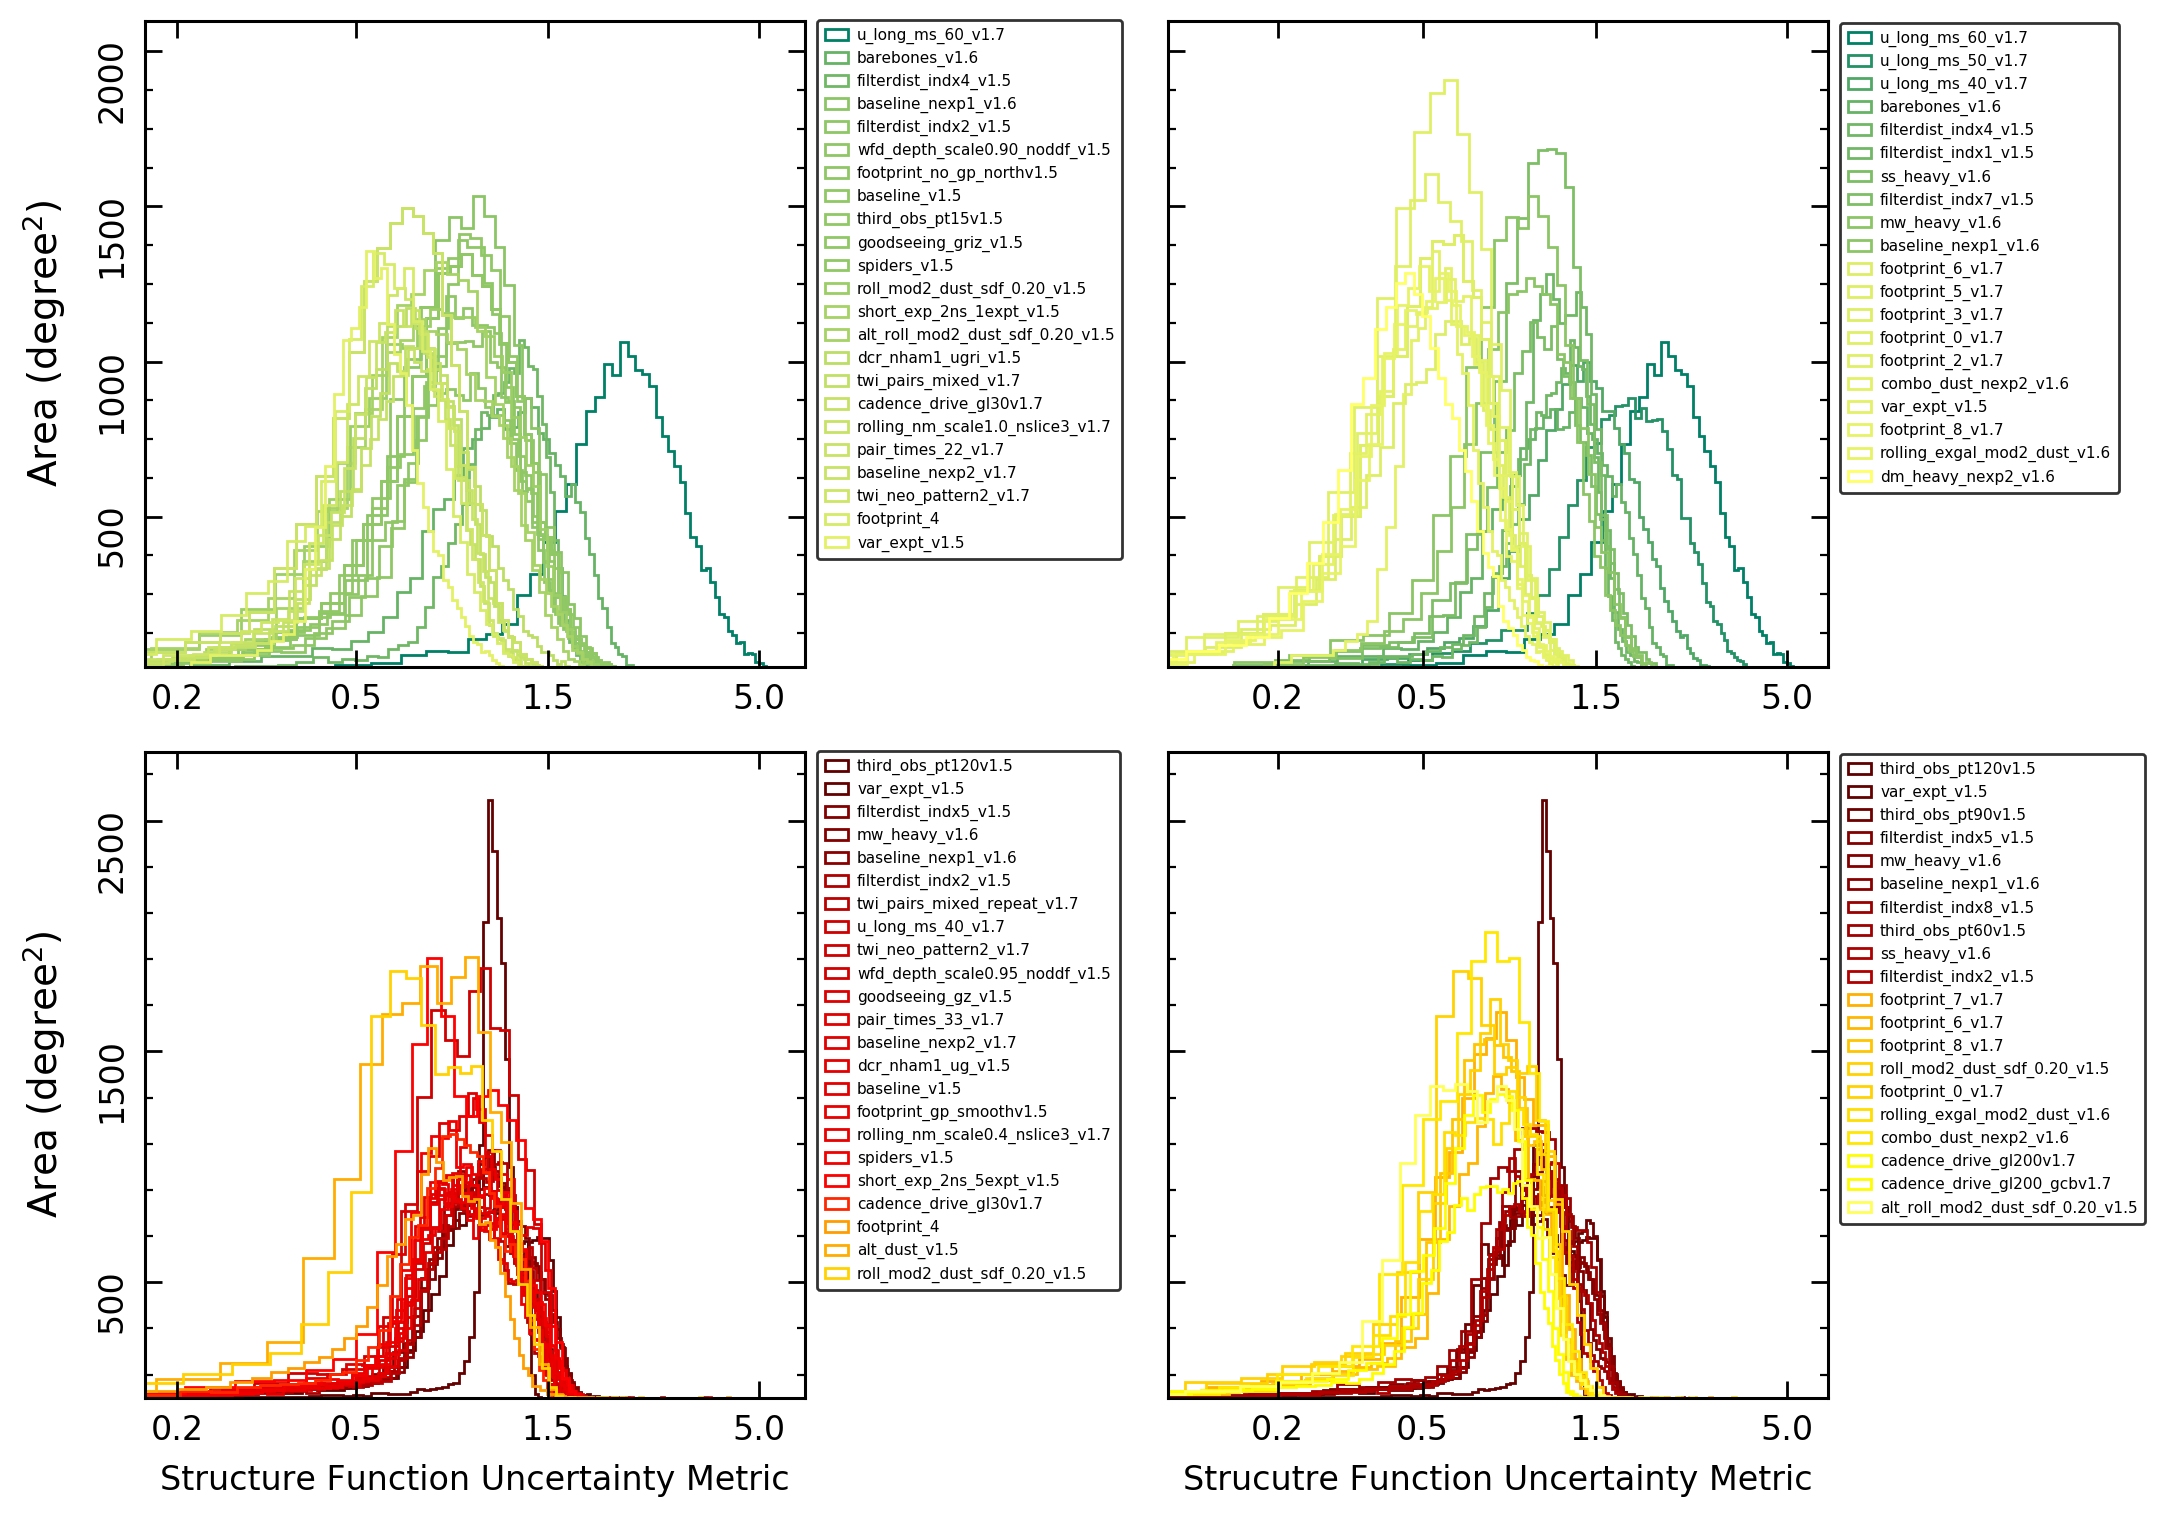

In [30]:
# start plot
fig = plt.figure(figsize=(11, 8.5), dpi=200)
ax3 = fig.add_axes([0.065, 0.15, 0.3, 0.38])
ax4 = fig.add_axes([0.53, 0.15, 0.3, 0.38])
ax1 = fig.add_axes([0.065, 0.58, 0.3, 0.38])
ax2 = fig.add_axes([0.53, 0.58, 0.3, 0.38])

# define normalizing run
norm_metric_u = summary_df_all.loc[norm_run, 'SFError_24.15_u_Median']

# create normalization object
uNormAll = mpl.colors.LogNorm(vmin=summary_df_all['SFError_24.15_u_Median'].min(), 
                              vmax=summary_df_all['SFError_24.15_u_Median'].max())
# set hist params
u_bins = 60
u_y_min = 20
u_y_max = 2500
density = False
    
## top left panel
## --------------
# take the best from each family, but keep all three baselines
# sort by family and median
# take the best from each family, but keep all three baselines
best_u_family_no_baseline = summary_df_no_ddf[
    summary_df_no_ddf.family != 'baseline'
].sort_values(['family', 'SFError_24.15_u_Median']).drop_duplicates(subset='family')

best_u_family = pd.concat([summary_df_no_ddf[summary_df_no_ddf.family == 'baseline'], 
                           best_u_family_no_baseline], 
                           axis=0).sort_values('SFError_24.15_u_Median')

for run in best_u_family.index:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_24.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(best_u_family.loc[run, 'SFError_24.15_u_Median']))
    ax1.hist(norm_metric_u/data, bins=u_bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# tick & format
ax1.set_xscale('log', basex=10)
ax1.set_xbound(lower=0.15, upper=6.5)
ax1.tick_params(top=True, right=True, which='both')
ax1.xaxis.set_major_locator(plt.FixedLocator([0.18, .5, 1.5, 5]))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/u_bins)**2))
ax1_y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in ax1_y_vals], rotation=90)

# label & legend
# ax1.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
ax1.legend(fontsize=5.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.45)
ax1.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=10)

# ylim
ax1.set_ylim([u_y_min, u_y_max])
## --------------------------------------------------------------------------------------------


## top right panel
## ----------------
# resort by metric value
summary_df_no_ddf_u_sort = summary_df_no_ddf.sort_values('SFError_24.15_u_Median')

# plot top 10
for run in summary_df_no_ddf_u_sort.index[:10]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_24.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(summary_df_no_ddf_u_sort.loc[run, 'SFError_24.15_u_Median']))
    ax2.hist(norm_metric_u/data, bins=u_bins, histtype='step', color=c, 
             density=density, label=f"{run[:run.find('v1.')+4]}")

# plot worst 10
for run in summary_df_no_ddf_u_sort.index[-10:]:
    
    if run == 'rolling_exgal_mod2_dust_sdf_0.80_nexp2_v1.6_10yrs':
        label = 'rolling_exgal_mod2_dust_v1.6'
    else:
        label = f"{run[:run.find('v1.')+4]}"
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_24.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(summary_df_no_ddf_u_sort.loc[run, 'SFError_24.15_u_Median']))
    ax2.hist(norm_metric_u/data, bins=u_bins, histtype='step', color=c, 
             density=density, label=label)


# tick & format
ax2.set_xscale('log', basex=10)
ax2.set_xbound(lower=0.1, upper=6.5)
ax2.tick_params(top=True, right=True, which='both')
ax2.xaxis.set_major_locator(plt.FixedLocator([.2, .5, 1.5, 5]))
ax2.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax2.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
# ax2.set_xlabel('Strucutre Function Uncertainty Metric', fontsize=12)
ax2.legend(fontsize=5.5, bbox_to_anchor=(1.0, 1.015), edgecolor='k', loc=2, labelspacing=0.45)

# make ax2 has same y lime as ax1
ax2.set_ylim([u_y_min, u_y_max])
ax2.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/u_bins)**2))
_ = ax2.set_yticklabels("")
## ------------------------------------------------------------------------------------------------

## -------------
## R-band
## -------------

# define normalizing run
norm_metric_r = summary_df_all.loc[norm_run, 'SFError_23.85_r_Median']

# create normalization object
rg = summary_df_all['SFError_23.85_r_Median'].max() - summary_df_all['SFError_23.85_r_Median'].min()
rNormAll = mpl.colors.LogNorm(vmin=summary_df_all['SFError_23.85_r_Median'].min()*0.93, 
                              vmax=summary_df_all['SFError_23.85_r_Median'].max()*1.1)
# set hist params
r_bins = 60
r_y_min = 20
r_y_max = 2050
density = False
    
## bottom left panel
## -----------------
# take the best from each family, but keep all three baselines
# sort by family and median
# take the best from each family, but keep all three baselines
best_r_family_no_baseline = summary_df_no_ddf[
    summary_df_no_ddf.family != 'baseline'
].sort_values(['family', 'SFError_23.85_r_Median']).drop_duplicates(subset='family')

best_r_family = pd.concat([summary_df_no_ddf[summary_df_no_ddf.family == 'baseline'], 
                           best_r_family_no_baseline], 
                           axis=0).sort_values('SFError_23.85_r_Median')

for run in best_r_family.index:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.hot(rNormAll(best_r_family.loc[run, 'SFError_23.85_r_Median']))
    ax3.hist(norm_metric_r/data, bins=r_bins, histtype='step', color=c, 
            density=density, label=f"{run.rsplit('_', 1)[0]}")

# tick & format
ax3.set_xscale('log', basex=10)
ax3.set_xbound(lower=0.15, upper=6.5)
ax3.tick_params(top=True, right=True, which='both')
ax3.xaxis.set_major_locator(plt.FixedLocator([0.18, .5, 1.5, 5]))
ax3.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax3.xaxis.set_minor_locator(plt.NullLocator())
ax3.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1500, 2500])/(54.967783/r_bins)**2))
ax3_y_vals = ax3.get_yticks()
ax3.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in ax3_y_vals], rotation=90)

# label & legend
ax3.set_xlabel('Structure Function Uncertainty Metric', fontsize=12)
ax3.legend(fontsize=5.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.45)
ax3.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=10)

# ylim
# ax1.set_ylim([20, 2450])
## ------------------------------------------------------------------------------------------------

## bottom right panel
## ------------------
# resort by metric value
summary_df_no_ddf_r_sort = summary_df_no_ddf.sort_values('SFError_23.85_r_Median')

# plot top 10
for run in summary_df_no_ddf_r_sort.index[:10]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.hot(rNormAll(summary_df_no_ddf_r_sort.loc[run, 'SFError_23.85_r_Median']))
    ax4.hist(norm_metric_r/data, bins=r_bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# plot worst 10
for run in summary_df_no_ddf_r_sort.index[-10:]:
    
    if run == 'rolling_exgal_mod2_dust_sdf_0.80_nexp2_v1.6_10yrs':
        label = 'rolling_exgal_mod2_dust_v1.6'
    else:
        label = f"{run[:run.find('v1.')+4]}"
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'SFError_23.85_r'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.hot(rNormAll(summary_df_no_ddf_r_sort.loc[run, 'SFError_23.85_r_Median']))
    ax4.hist(norm_metric_r/data, bins=r_bins, histtype='step', color=c, 
             density=density, label=label)

# tick & format
ax4.set_xscale('log', basex=10)
ax4.set_xbound(lower=0.1, upper=6.5)
ax4.tick_params(top=True, right=True, which='both')
ax4.xaxis.set_major_locator(plt.FixedLocator([.2, .5, 1.5, 5]))
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax4.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax4.set_xlabel('Strucutre Function Uncertainty Metric', fontsize=12)
ax4.legend(fontsize=5.5, bbox_to_anchor=(1.0, 1.015), edgecolor='k', loc=2, labelspacing=0.45)

# make ax2 has same y lime as ax1
# ax4.set_ylim([20, 2450])
ax4.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1500, 2500])/(54.967783/r_bins)**2))
_ = ax4.set_yticklabels("")
## ------------------------------------------------------------------------------------------------

# plt.savefig('figs/sf_cad_note_wfd.pdf')